/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252

,Number of Genes
0,23
1,48
2,156
3,132
4,31
5,154
6,119
7,177
8,75
9,29


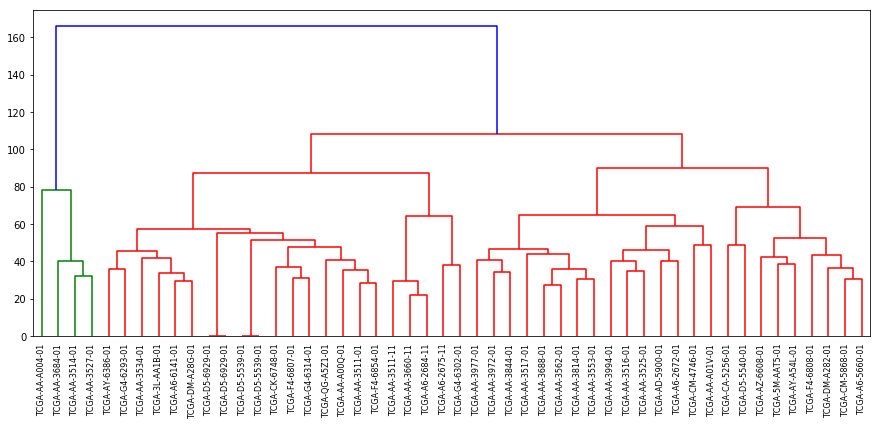

,0
0,2.386659e-01
1,1.339186e-01
2,8.239970e-02
3,6.377466e-02
4,4.851374e-02
5,4.132317e-02
6,3.846465e-02
7,2.636165e-02
8,2.617169e-02
9,2.027959e-02


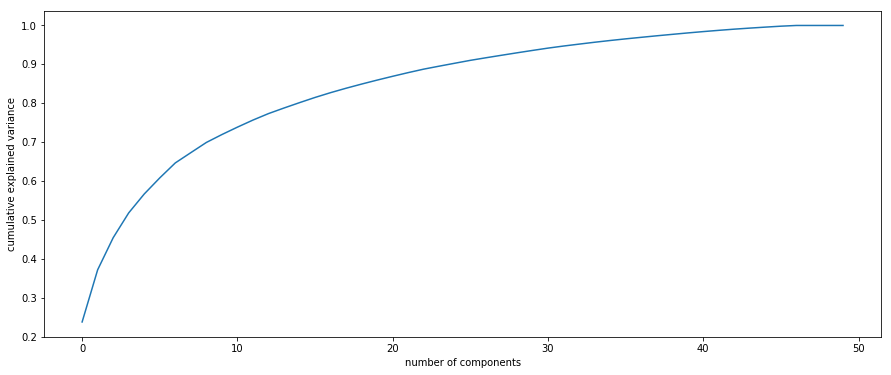

,0
0,8.227602e-01
1,4.258248e-02
2,2.345997e-02
3,1.516051e-02
4,1.122303e-02
5,8.484998e-03
6,6.912833e-03
7,5.784000e-03
8,4.856420e-03
9,4.205334e-03


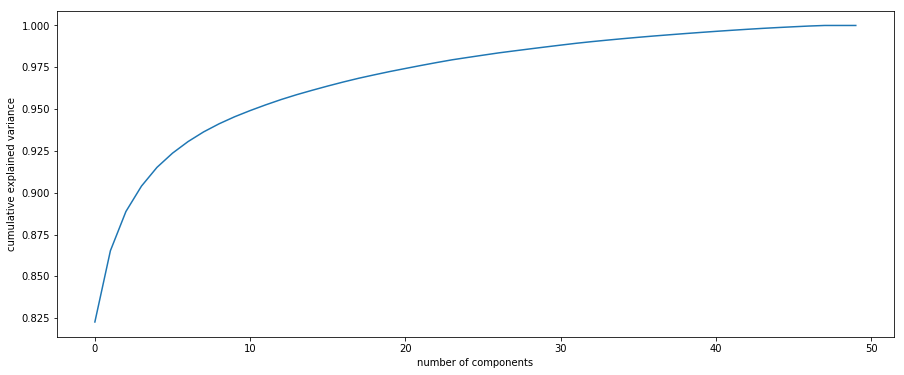

,0,1,2,3,4,5,6,7,8,9,...,491,492,493,494,495,496,497,498,499,500
0,gene,TCGA-3L-AA1B-01,TCGA-4N-A93T-01,TCGA-4T-AA8H-01,TCGA-5M-AAT4-01,TCGA-5M-AAT5-01,TCGA-5M-AAT6-01,TCGA-5M-AATA-01,TCGA-5M-AATE-01,TCGA-A6-2671-11,...,TCGA-AA-A03J-01,TCGA-AY-4070-01,TCGA-AY-4071-01,TCGA-AZ-4308-01,TCGA-AZ-4681-01,TCGA-CM-4746-01,TCGA-CM-4748-01,TCGA-CM-4750-01,TCGA-CM-4752-01,TCGA-CM-5341-01
1,?|100133144,4.17672967016085,2.14779511328845,3.3073556599663,2.98502674054015,3.61547515274644,1.98684777360139,2.85531202945426,3.53965513692041,1.75501573602346,...,3.07922448856104,3.47421537126437,5.77604870125496,3.65328936215566,3.61172715607118,4.86649755757547,NaN,4.74054444532578,3.34470069354772,3.63643901567511
2,?|100134869,3.97856174947575,2.09649800925022,3.49865936049888,4.2296494436055,4.38422944154545,3.91333943475382,3.51743948334858,2.7878503341913,2.74148855924981,...,6.29622244553511,6.28825703837177,5.75516532778899,4.00958007739697,4.08651204657428,5.15329057495693,NaN,5.74696032879399,NaN,4.88372344338014
3,?|10357,7.17393092837943,7.15644616995887,7.16187458522559,7.19167713323198,8.03623351750383,7.83448305922483,6.95692321757353,7.9111792383093,5.91563562343031,...,8.24837022000974,8.99347369046927,8.66194408720761,8.10865303908421,9.23356575442573,8.19511280658714,8.33384007650942,9.0269889581561,9.385540831427,9.99723538075837
4,?|10431,9.59742223054581,10.2110276515451,9.79493598761776,10.3225487710644,10.3441217752136,9.88514084405582,9.96463659718453,9.2451937704205,9.352416027902,...,10.1774124366231,9.24273944304594,9.91093393811282,10.1091884141343,10.8065586438363,10.531792472571,9.56052772819231,10.5870577704056,10.5638655922707,11.1172828371451
5,?|155060,8.78781410184795,9.02794081982301,8.17024706719613,8.56802488215471,8.12647940518528,7.67768863833753,8.48482490779185,9.20548415460695,5.33097422634287,...,8.57823605817943,8.62638656790408,7.79959182427554,8.45289931349718,6.37757668981765,5.72002668312772,7.15842892979591,6.7843521674087,7.32451901133418,4.97583650663025
6,?|26823,0.951736979969831,-1.04751732556952,1.54818998907857,1.10534284028622,-0.0156658551595116,0.39231742277876,-1.33061033798716,1.04222407376298,-0.25394526470306,...,1.33508302345125,1.00432160595009,0.0514417113826102,NaN,NaN,1.59072177000984,NaN,NaN,NaN,NaN
7,?|388795,1.27369491003708,1.27441076931784,1.54818998907857,1.10534284028622,3.15429155583566,2.19965664194774,3.36988520228402,1.45727908647152,-0.25394526470306,...,1.92002646271441,3.17426258930279,0.0514417113826102,2.61999982982136,NaN,NaN,6.35107527009629,-0.0101343771337132,2.49669242613819,1.22094900446678
8,?|390284,1.53674920564803,1.53744517515163,1.87010821766418,0.368377246120017,1.79173073618948,1.71422353357419,-0.330610337987163,NaN,1.91594150598015,...,3.65698824455879,5.36188764347457,4.57496129674126,4.84240063256053,3.16812852957695,5.59074571893193,5.3510735027948,5.03433018244915,5.21916464745014,6.05384119026775
9,?|57714,8.70163326252149,7.50320878441626,8.61428470169071,8.69178259526712,8.08503473766667,9.43804578220761,9.23549563766447,9.05161599271726,7.98202499026758,...,8.71010144124894,8.88391798720922,8.59055785890293,8.07944104897044,5.86856330927324,7.84813277898635,8.43853738363451,8.38654110554295,8.08166238243025,5.50635122332903


In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
# import data
data = pd.read_csv('/Users/Developer/Documents/cse391/cancer_project_cse391/data/Cancer_Data.txt', sep="\t", header=None)

# create data frame
df = pd.DataFrame(data)

# get columns labels
columns = df.iloc[0, 1:]

# index labels
index = df.iloc[17:,0]

# get actual data
data1 = df.iloc[17:,1:]

#set index labels to data
data1.index = index

# set column lables to data
data1.columns = columns

# data preprocessing
data1 = data1.dropna()

# generate random sample by getting random indexes for patient ids and genes 
patient_indexes = np.random.randint(0,len(data1.columns), 50)
gene_indexes = np.random.randint(0, len(data1), 2000)

# extract sample data from indexes
sample_data = data1.iloc[gene_indexes, patient_indexes]

# Applying k-means to cancer sample data
kmeans = KMeans(n_clusters=20, init= 'k-means++')
y_kmeans = kmeans.fit_predict(sample_data)
#print(y_kmeans.shape)

#number of genes in each cluster
display(pd.DataFrame(np.bincount(y_kmeans), columns = ["Number of Genes"]))

# Fitting Hierarcical clustering to the sample data
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
import scipy.cluster.hierarchy as sch
dendrogram = sch.dendrogram(sch.linkage(sample_data.T, method = 'ward'), labels=sample_data.columns)
plt.show()

# PERFORM PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=None)
pca.fit(sample_data.T)
explained_variance = pca.explained_variance_ratio_
display(pd.DataFrame(explained_variance))
plt.plot(np.cumsum(explained_variance))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
plt.show()
pca.fit(sample_data)
explained_variance = pca.explained_variance_ratio_
display(pd.DataFrame(explained_variance))
plt.plot(np.cumsum(explained_variance))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
plt.show()

display(data)

In [147]:
## mat file  earlier than v7.3
import scipy.io
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
import itertools
mat = scipy.io.loadmat('/Users/Developer/Documents/cse391/cancer_project_cse391/data/CSE391_classificatin_project.mat')
X = pd.DataFrame(mat.get('X'))
Y = pd.DataFrame(mat.get('Y'))
X = X.T
Y = Y.T
X['class'] = 0
#display(X)
Y['class'] = 1
display(X)
display(Y)

,0,1,2,3,4,5,6,7,8,9,...,191,192,193,194,195,196,197,198,199,class
0,10.426991,9.834758,8.075885,10.545622,5.996158,10.599672,10.525884,0.536749,3.858657,10.631244,...,4.929043,7.733124,12.995389,6.144352,4.039226,10.271436,5.411196,8.307115,7.834407,0
1,10.843486,9.351440,7.147218,9.323149,7.092013,11.252528,8.827443,-1.047517,0.537445,11.425152,...,3.274396,5.822827,13.273474,7.631942,1.537445,9.304505,3.344786,9.514704,8.081744,0
2,11.092194,9.416648,8.220621,8.322983,4.757647,10.471523,10.423177,0.548239,1.133169,11.254691,...,4.718120,8.390546,12.322983,5.656719,3.007626,10.681338,3.870128,9.019871,7.393686,0
3,11.168983,10.239724,7.541613,9.555705,7.945781,10.925178,10.896155,-1.216585,2.590746,11.879776,...,3.641373,9.488158,13.437746,6.469891,2.870858,9.375847,4.455814,9.124353,7.114307,0
4,10.868161,9.015701,7.039655,10.890135,7.439700,11.018139,10.347412,7.509195,-1.015666,11.606195,...,4.193827,8.851651,13.866155,6.579219,3.306306,9.643476,4.791726,9.201118,7.237038,0
5,10.476430,9.541347,7.855810,11.763791,1.392262,10.922205,10.684608,2.392290,5.369568,11.248323,...,4.346482,2.977243,12.605238,6.059044,3.299171,9.959292,6.120207,9.312639,6.696068,0
6,10.828367,8.975651,7.022589,11.774204,7.177236,10.598700,10.429746,-0.330610,2.476796,12.024380,...,3.669446,4.954843,13.068987,6.291493,5.588304,10.069787,6.200822,9.139083,6.878895,0
7,10.603223,9.537962,7.661862,10.593001,3.264642,10.326885,10.619683,7.509195,2.627210,11.317214,...,4.627216,9.410033,14.109688,6.238651,3.849609,10.341462,3.849609,8.119069,7.858171,0
8,11.835792,8.870933,7.955464,10.182202,9.626360,11.125931,10.256280,7.509195,5.315867,10.547719,...,2.746012,5.253804,13.086695,3.846564,5.790405,11.456171,5.603991,11.000744,5.925919,0
9,11.142399,8.746882,8.021811,10.797417,8.794249,10.630315,10.495246,-0.842439,6.134905,10.260256,...,4.617057,4.111824,13.086605,5.157626,4.515176,10.875301,5.830050,10.655975,6.052442,0


,0,1,2,3,4,5,6,7,8,9,...,191,192,193,194,195,196,197,198,199,class
0,22.238704,18.760719,15.361413,21.733261,16.424466,24.628711,21.326567,11.983557,11.318460,17.433991,...,19.053616,22.558911,18.055002,11.456578,13.686536,23.611557,11.174566,15.560124,19.996824,1
1,24.444207,22.934594,15.927805,17.029654,14.372850,25.679911,18.957815,10.229044,11.758503,25.404043,...,8.384137,20.659805,22.354012,16.766685,9.461927,21.560539,18.623299,20.832438,14.397845,1
2,23.558030,21.879838,16.137480,15.283998,17.750697,15.775781,26.012576,8.152097,8.582408,25.970975,...,20.581590,20.007036,23.452323,12.167964,13.470907,23.686489,14.563884,14.185323,21.295216,1
3,21.215501,17.404104,17.153474,18.761508,16.313953,22.279996,20.666805,8.344681,15.769364,23.176000,...,16.218714,20.197982,21.821373,15.040366,12.186027,17.073327,11.713446,16.054341,19.164493,1
4,20.312468,18.026051,18.559101,23.937632,16.887475,23.302795,16.914885,16.394916,3.243517,22.458688,...,19.902098,17.874618,24.148712,10.516921,14.610845,15.308390,9.002602,15.916739,17.234340,1
5,22.328424,18.686132,20.970252,26.770246,5.713930,15.689923,20.094004,10.756653,19.510297,19.855782,...,15.995633,12.336956,22.080556,16.472230,10.305599,21.150003,17.586262,22.128531,16.046425,1
6,20.029089,21.257038,18.244129,20.582754,19.642655,13.829480,17.128564,3.736753,15.433452,21.310162,...,16.506921,13.024864,22.628235,15.992530,17.177303,25.045653,14.335208,15.150984,16.646988,1
7,19.705608,21.704446,16.042489,21.651336,15.858130,23.041331,18.725630,15.965917,4.290846,18.886012,...,10.208733,18.376059,28.637733,18.237486,12.676165,23.796681,15.493743,15.134856,18.414816,1
8,17.263833,15.767263,21.918661,19.161840,22.416668,21.586114,24.346643,22.091921,15.478320,18.610387,...,15.814642,10.541971,22.140318,16.665654,18.409599,25.548999,12.151543,17.153030,16.104935,1
9,21.672759,19.324428,17.673543,24.358870,16.352411,22.332573,22.067099,0.374705,23.891729,16.520092,...,16.935865,13.603049,22.815515,19.250063,10.590654,19.206413,15.097719,18.606484,11.380932,1


,0,1
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
5,0,0
6,0,0
7,0,0
8,0,0
9,0,0


Confusion matrix, without normalization
[[50  0]
 [ 0 50]]
Normalized confusion matrix
[[1. 0.]
 [0. 1.]]


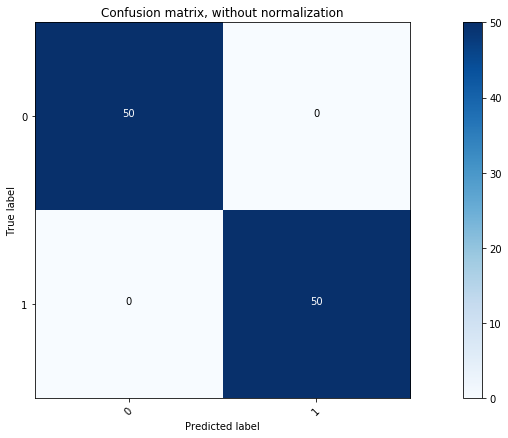

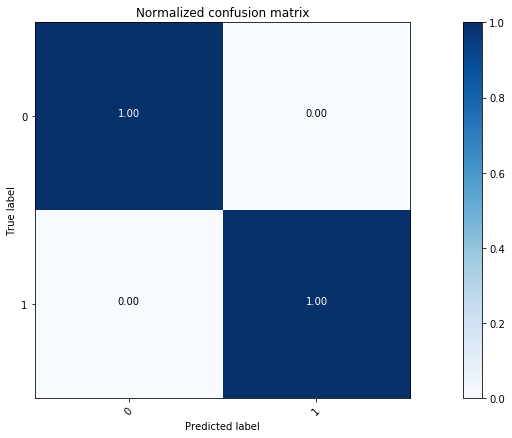

In [182]:

# data = pd.concat([X,Y],ignore_index=True)
# display(data)
X_features = X.iloc[:, :-1]
X_class = X.iloc[:,-1]
# Split the data into a training set and a test set
X_train, X_test, X_class_train, X_class_test = train_test_split(X_features, X_class, test_size = .2, random_state=0)

#display(X_class_train.T)
#print(X_class_train.T.shape)

Y_features = Y.iloc[:, :-1]
Y_class = Y.iloc[:,-1]
Y_train, Y_test, Y_class_train, Y_class_test = train_test_split(Y_features, Y_class, test_size = .2, random_state=0)
# Run classifier, using a model that is too regularized (C too low) to see
# the impact on the results

x_final_train = pd.concat([X_train,Y_train],ignore_index=True)
y_final_train = pd.concat([X_class_train,Y_class_train],ignore_index=True)
x_final_test = pd.concat([X_test,Y_test],ignore_index=True)
y_final_test = pd.concat([X_class_test,Y_class_test],ignore_index=True)

classifier = svm.SVC(kernel = "linear")
#y_pred = classifier.fit(X_train, y_train).predict(X_test)
y_final_pred = classifier.fit(x_final_train, y_final_train).predict(x_final_test)
display(pd.concat([pd.DataFrame(y_final_pred),pd.DataFrame(y_final_test)],ignore_index=True, axis=1))

from sklearn.metrics import confusion_matrix
# cm = confusion_matrix(y_final_test, y_final_pred)
# display(cm)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting normalize=True.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_final_test, y_final_pred)

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
class_names = ['0','1']
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()